In [1]:
# import packages

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os, requests

from sklearn.decomposition import PCA

In [2]:
# data retrieval

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)
                
alldat = np.load(fname, allow_pickle=True)['dat']

In [3]:
# data pre-processing

def get_PCA_data(subject = 0, im_vs_real = 0, vector = True):
    """
    Get brain activity data from subject performing imagery or real movement
    
    Args:
    - subject: number of subject (0-6)
    - im_vs_real: 0 real, 1 imaginary
    
    Returns:
    - samples: 2-dim. numpy array (trials for each channel x time) 
        with voltage time series in uV
    - labels: 2-dim. numpy array (trials for each channel x 2) 
        with number of brodman area and movement type for each sample
    """
    
    data = alldat[subject][im_vs_real]
    
    trange = np.arange(0, 3000)
    V = data['V'].astype('float32')
    scale_uv = data['scale_uv'].astype('float32')

    number_of_trials = 60 # len(data['t_on']) = 60 for all cases
    number_of_channels = len(data['locs'])

    trial_indices = (data['t_on'][:, np.newaxis] + trange).flatten() 
    
    labels = np.zeros((number_of_trials, number_of_channels, 2)) # trials for each electrode location x 2, 
                                                                 # with brodmann area & movement type as columns
    samples = np.zeros((number_of_trials, number_of_channels, 3000)) # trials for each electrode location x time

    movement_types = data['stim_id']
    labels[:,:,1] = np.tile(movement_types, (number_of_channels, 1)).T

    # iterate through all channels with this loop
    for ch_num in range(number_of_channels):

        number_of_brodmann_area = int(data['Brodmann_Area'][ch_num][14:])
        labels[:, ch_num,  0] = np.full(number_of_trials, number_of_brodmann_area)
        
        V_in_uv = V[:, ch_num] * scale_uv[ch_num]
        samples[:, ch_num, :] = V_in_uv[trial_indices].reshape((number_of_trials, 3000))

    # choose time series vectors for PCA
    if vector == True:
        labels = labels.reshape((number_of_trials * number_of_channels, 2))
        samples = samples.reshape((number_of_trials * number_of_channels, 3000))
    
    return(samples, labels)

def get_dataframe():
    """ Get dataframe with samples and labels for PCA
    
    Args:
        None
    
    Returns: dataframe with columns..
    - subject: number of subject (0-6)
    - im_vs_real: 0 real, 1 imaginary
    - samples: 2-dim. numpy array (trials for each channel x time) 
        with voltage time series in uV
    - labels: 2-dim. numpy array (trials for each channel x 2) 
        with number of brodman area and movement type for each sample
    """

    # initialize the data frame with column names
    df = pd.DataFrame(columns=['Subject', 'Re vs Im', 'PCA_samples', 'PCA_labels'])

    idx = 0 # this is a variable for setting the index of every row of this data frame
    trange = np.arange(0, 3000) # needed for splitting voltagfe-time-series

    # iterate through all subjects with this loop
    for subject in range(alldat.shape[0]):

        # iterate through real vs imagery with this loop
        for r_vs_i in range(alldat.shape[1]):

            samples, labels = get_PCA_data(subject, im_vs_real)
        
            # place gather the relevant information with the column order 
            # as a dictionary and place this dictionary to the respective 
            # row (indexed by variable idx) of the data frame
            df.loc[idx] = {'Subject': subject, 
                           'Re vs Im': r_vs_i, 
                           'PCA_labels': labels, 
                           'PCA_samples': samples}
      
            # increment the index number to put the upcoming data to the next row
            idx += 1
    
    return(df)

def get_random_data(correlation_degree = 0.5, number_of_channels = 46, number_of_trials =  60):
    """
    Get data for PCA with same format as samples in "get_PCA_data", but with random entries 
    drawn form a uniform distribution between 0 and 1
    """
    number_of_samples = int(number_of_trials * number_of_channels * 3000)
    random_samples_re = np.random.uniform(0, 1, number_of_samples)
    random_samples_im = np.random.uniform(0, 1, number_of_samples)
    
    # create "correlated" im data by randomly generating mask (sampling from bernoulli distribution)
    if correlation_degree > 0:
        random_mask = np.random.binomial(1, p = correlation_degree, size = number_of_samples)
        flipped_random_mask = (random_mask == 0)
        random_samples_im = random_samples_re * random_mask + random_samples_im * flipped_random_mask
    
    # reshape 
    random_samples_re = random_samples_re.reshape((number_of_trials * number_of_channels, 3000))
    random_samples_im = random_samples_im.reshape((number_of_trials * number_of_channels, 3000))
    
    return(random_samples_re, random_samples_im)

In [4]:
# dimensionality reduction

def fit_PCA(X_re, X_im, latent_dim = 2):
    
    X = np.concatenate((X_re, X_im), axis = 0)
    latent_X = PCA(n_components=latent_dim).fit_transform(X)
    latent_X_re, latent_X_im = latent_X[:X_re.shape[0], :],  latent_X[X_re.shape[0]:, :]
    
    return(latent_X_re, latent_X_im)

In [5]:
# computation of correlation matrices

def latent_cross_corr(latent_samples, latent_dim):
    
    # make sure that samples have right shape (ntrials x nchan x latent dim)
    samples = np.reshape(latent_samples, (60, int(latent_samples.shape[0] / 60), latent_dim)) 
    
    # compute correlation matrix for each latent dimension
    corr_mats = []
    for f in range(latent_dim):
        samples_f = samples[:,:,f].T # get right shape of samples for np.corrcoef
        corr_coef_f = np.corrcoef(samples_f)
        corr_mats.append(corr_coef_f)

    return(corr_mats)

def correlate_matrices(corr1, corr2):
    """Correlate off-diagonal elements of two 2-dim matrices

    Args:
        corr1 (np.ndarray): S x S correlation coefficient matrix
        corr2 (np.ndarray): S x S correlation coefficient matrix to correlate with corr1

    Returns:
        float: correlation coefficient between the off-diagonal elements
              of corr1 and corr2

    """

    # Extract off-diagonal elements of each RDM
    ioffdiag = np.triu_indices(corr1.shape[0], k=1)  # indices of off-diagonal elements
    corr1_offdiag = corr1[ioffdiag]
    corr2_offdiag = corr2[ioffdiag]

    # compute correlation coefficient 
    corr_coef = np.corrcoef(corr1_offdiag, corr2_offdiag)[0,1]

    return corr_coef

def diff_measure(corr_coeff):
    # compute a measure of dissimilarity from correlation 
    return((1 - corr_coeff) / 2)

In [6]:
def compute_cross_corrs(latent_dim = 2, mode = "compare_first", random = False, corr_degree = 0):
    """...
    
    args:
        mode: 
        - compare_first: compare im and real corr mats for each latent dim first and average afterwards
        - average_first: average im and real corr mats resp. over latent dim and compare them afterwards
        - max: use corr along latent dim with lowest correlation, use order which gives highest difference
        random: true to compute random benchmark, false to work on empirical dataset
    ...
    
    """

    corrs = [] 
    # diffs_stds = [] # for error propagation
    
    for subject in range(7):
        
        if random == False: 
            X_re, y_re = get_PCA_data(subject, im_vs_real = 0)
            X_im, y_im = get_PCA_data(subject, im_vs_real = 1)
        else:
            X_re, X_im = get_random_data(corr_degree)
        
        latent_X_re, latent_X_im = fit_PCA(X_re, X_im, latent_dim)
        
        corr_mats_re = latent_cross_corr(latent_X_re, latent_dim)
        corr_mats_im = latent_cross_corr(latent_X_im, latent_dim)
        
        if mode == "compare_first":
            cross_corrs = []
            for f in range(latent_dim):
                cross_corr_f = correlate_matrices(corr_mats_re[f], corr_mats_im[f])
                cross_corrs.append(cross_corr_f)
            corr = np.mean(np.array(cross_corrs))
    
        elif mode == "average_first": 
            cross_corr_re = np.mean(np.stack(corr_mats_re, axis = 0), axis = 0)
            cross_corr_im = np.mean(np.stack(corr_mats_im, axis = 0), axis = 0)
            corr = correlate_matrices(corr_re, corr_im)
        
        """
        elif mode == "max":
            ...
        
        """
        
        corrs.append(corr)
        
    return(corrs)

In [7]:
# for all subjects, for all dimensions

latent_dims = np.array([1,2,3,4,5,6,7,8,9,10,20,50,80,100,200,500,1000,2000,2999])
latent_corr_coefs_means_0 = []
latent_corr_coefs_stds_0 = []

for latent_dim in latent_dims:
    latent_cross_corrs = compute_cross_corrs(latent_dim)
    corr_mean, corr_std = np.mean(latent_cross_corrs), np.std(latent_cross_corrs)
    latent_corr_coefs_means_0.append(corr_mean)
    latent_corr_coefs_stds_0.append(corr_std)

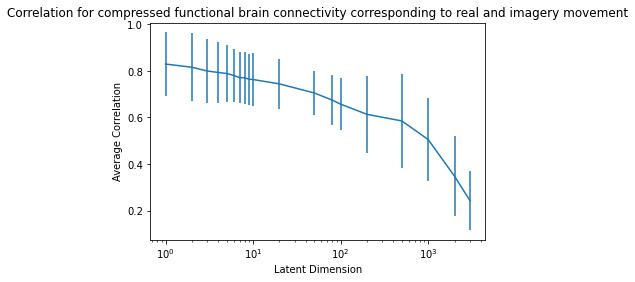

In [8]:
# plot

fig = plt.figure()
plt.errorbar(latent_dims, np.array(latent_corr_coefs_means_0), yerr = np.array(latent_corr_coefs_stds_0))
plt.title("Correlation for compressed functional brain connectivity corresponding to real and imagery movement")
plt.ylabel("Average Correlation")
plt.xlabel("Latent Dimension")
plt.xscale("log")
# plt.xlim(0, 20)

In [9]:
# compare wih random benchmark

latent_dims = np.array([1,2,3,4,5,6,7,8,9,10,20,50,80,100,200,500,1000,2000,2999])
latent_corr_coefs_means_2 = []
latent_corr_coefs_stds_2 = []

for latent_dim in latent_dims:
    latent_cross_corrs = compute_cross_corrs(latent_dim, random = True)
    corr_mean, corr_std = np.mean(latent_cross_corrs), np.std(latent_cross_corrs)
    latent_corr_coefs_means_2.append(corr_mean)
    latent_corr_coefs_stds_2.append(corr_std)

Text(0.5, 0, 'Latent Dimension')

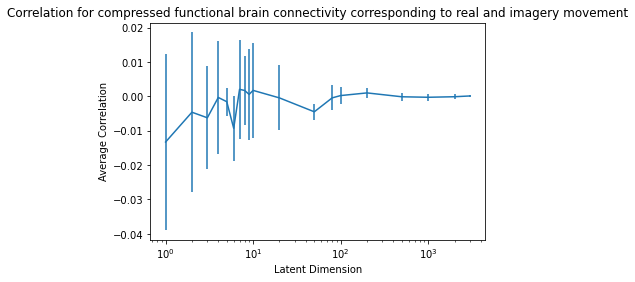

In [10]:
# plot

fig = plt.figure()
plt.errorbar(latent_dims, np.array(latent_corr_coefs_means_2), yerr = np.array(latent_corr_coefs_stds_2))
plt.title("Correlation for compressed functional brain connectivity corresponding to real and imagery movement")
plt.ylabel("Average Correlation")
plt.xscale("log")
plt.xlabel("Latent Dimension")
# plt.xlim(0, 10)

In [11]:
# compare wih random correlated benchmark

latent_dims = np.array([1,2,3,4,5,6,7,8,9,10,20,50,80,100,200,500,1000,2000,2999])
latent_corr_coefs_means_1 = []
latent_corr_coefs_stds_1 = []

for latent_dim in latent_dims:
    latent_cross_corrs = compute_cross_corrs(latent_dim, random = True, corr_degree = 0.99)
    corr_mean, corr_std = np.mean(latent_cross_corrs), np.std(latent_cross_corrs)
    latent_corr_coefs_means_1.append(corr_mean)
    latent_corr_coefs_stds_1.append(corr_std)

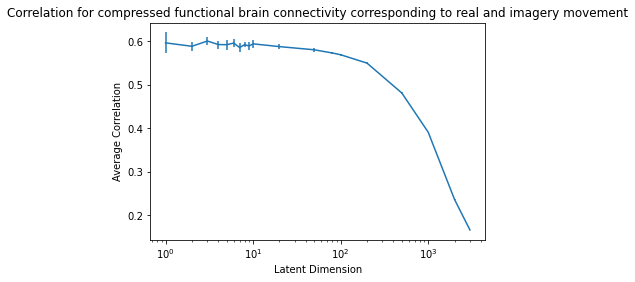

In [12]:
# plot

fig = plt.figure()
plt.errorbar(latent_dims, np.array(latent_corr_coefs_means_1), yerr = np.array(latent_corr_coefs_stds_1))
plt.title("Correlation for compressed functional brain connectivity corresponding to real and imagery movement")
plt.ylabel("Average Correlation")
plt.xlabel("Latent Dimension")
plt.xscale("log")
# plt.xlim(0, 20)

In [14]:
# compare wih random correlated benchmark

latent_dims = np.array([1,2,3,4,5,6,7,8,9,10,20,50,80,100,200,500,1000,2000,2999])
latent_corr_coefs_means_3 = []
latent_corr_coefs_stds_3 = []

for latent_dim in latent_dims:
    latent_cross_corrs = compute_cross_corrs(latent_dim, random = True, corr_degree = 0.99)
    corr_mean, corr_std = np.mean(latent_cross_corrs), np.std(latent_cross_corrs)
    latent_corr_coefs_means_3.append(corr_mean)
    latent_corr_coefs_stds_3.append(corr_std)

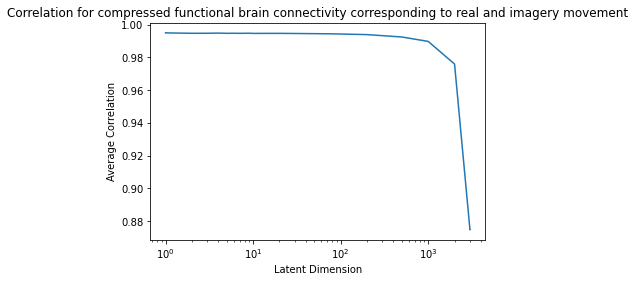

In [15]:
# plot

fig = plt.figure()
plt.errorbar(latent_dims, np.array(latent_corr_coefs_means_3), yerr = np.array(latent_corr_coefs_stds_3))
plt.title("Correlation for compressed functional brain connectivity corresponding to real and imagery movement")
plt.ylabel("Average Correlation")
plt.xlabel("Latent Dimension")
plt.xscale("log")
# plt.xlim(0, 20)

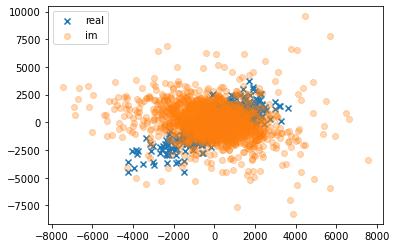

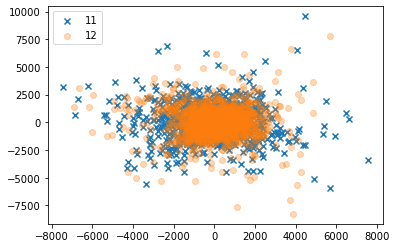

In [16]:
# visualize

X_re, y_re = get_PCA_data(subject = 0, im_vs_real = 0)
X_im, y_im = get_PCA_data(subject = 0, im_vs_real = 1)
latent_X_re, latent_X_im = fit_PCA(X_re, X_im, latent_dim = 2)

# real vs im
fig = plt.figure()
plt.scatter(latent_X_re[:,0], latent_X_re[:,1], marker = "x", label = "real")
plt.scatter(latent_X_im[:,0], latent_X_im[:,1], marker = "o", label = "im", alpha = 0.3)
plt.legend()


# by movement type
latent_X = np.concatenate((latent_X_re, latent_X_im), axis = 0)
y = np.concatenate((y_re, y_im), axis = 0)
latent_X_11 = latent_X[y[:,1] == 11]
latent_X_12 = latent_X[y[:,1] == 12]

fig = plt.figure()
plt.scatter(latent_X_11[:,0], latent_X_11[:,1], marker = "x", label = "11")
plt.scatter(latent_X_12[:,0], latent_X_12[:,1], marker = "o", label = "12", alpha = 0.3)
plt.legend()

In [ ]:
# Corr of electrodes in latent space

samples_re, samples_im = np.reshape(latent_X_re, (ntrials, nchan, latent_dim)), np.reshape(latent_X_im, (ntrials, nchan, latent_dim))

# first option: first average over latent dimension, then compare im & re:     
corr_mats_re, corr_mats_im = [], []

for f in range(latent_dim):
    samples_re_f = samples_re[:,:,f].T # get right shape of samples for np.corrcoef
    samples_im_f = samples_im[:,:,f].T
    corr_mats_re.append(np.corrcoef(samples_re_f))
    corr_mats_im.append(np.corrcoef(samples_im_f))
    
corr_re = np.mean(np.stack(corr_mats_re, axis = 0), axis = 0) # average over latent dimensions
corr_im = np.mean(np.stack(corr_mats_im, axis = 0), axis = 0)

corr_s0 = correlate_CCM(corr_re, corr_im)
d_s0 = (1 - corr_s0) / 2
print(corr_s0, d_s0)

# second option: first compare im & re for every latent dim, then average over f: 
corrs_f = []

for f in range(latent_dim):
    samples_re_f = samples_re[:,:,f].T # get right shape of samples for np.corrcoef
    samples_im_f = samples_im[:,:,f].T
    corr_f_re = np.corrcoef(samples_re_f)
    corr_f_im = np.corrcoef(samples_im_f)
    corr_f = correlate_CCM(corr_f_im, corr_f_re)
    corrs_f.append(corr_f)

corr_s0 = np.mean(np.array(corrs_f))
d_s0 = (1 - corr_s0) / 2
print(corr_s0, d_s0)

# third option: use minimal correlated feature
corrs_f = []

for f in range(latent_dim):
    samples_re_f = samples_re[:,:,f].T # get right shape of samples for np.corrcoef
    samples_im_f = samples_im[:,:,f].T
    corr_f_re = np.corrcoef(samples_re_f)
    corr_f_im = np.corrcoef(samples_im_f)
    corr_f = correlate_CCM(corr_f_im, corr_f_re)
    corrs_f.append(corr_f)

corr_s0 = np.min(np.array(corrs_f))
d_s0 = (1 - corr_s0) / 2
print(corr_s0, d_s0)